<a href="https://colab.research.google.com/github/thisarli/ResNet-PyTorch-Classification/blob/main/ResNet_in_PyTorch_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and Imports

In [1]:
!pip install -q torch torchvision sklearn seaborn

  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from torch.nn import Conv2d, MaxPool2d, AvgPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Set up GPU
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

# ResNet 30 implementation

In [ ]:
# Residual block

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 

        if stride != 1 or inchannel != outchannel: 
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        out = self.left(x) 
        out += self.shortcut(x) 
        out = F.relu(out) 
        return out


    
# ResNet 30 (for given dataset ResNet-18 converged to high bias & low variance
# after dataset augmentation; thus more complex architecture was needed)

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes = 20):
        super(ResNet, self).__init__()
        
        self.inchannel = 16
        self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(16), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 3, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 4, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 6, stride = 2)
        self.layer6 = self.make_layer(ResidualBlock, 512, 3, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet30():
    return ResNet(ResidualBlock)

## Accuracy computation and training function

In [ ]:

def confusion(preds, y):
  """
  Plots confusion matrix for all labels in dataset
  """
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']

  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax)

  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  """
  Function to plot sample of incorrect images
  """
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']

  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [ ]:
def check_accuracy(loader, model, analysis=False):
    """
    Function to compute accuracy on validation and test set
    """
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)

def train_part(model, optimizer, epochs=1):
    """
    Function to train the model using cross-entropy loss
    """
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % 10 == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        
        # Compute and plot both the train and 
        # val set accuracies at each epoch, to see if the model suffers from
        # bias or variance. This is crucial to inform the changes to the
        # architecture required to improve performance.
        print("Train set accuracy")
        train_acc = check_accuracy(loader_train, model)
        print("Val set accuracy")
        dev_acc = check_accuracy(loader_val, model)
        plt.scatter(e, train_acc)
        plt.scatter(e, dev_acc)

cuda:0


# Download NaturalImageNet dataset

In [ ]:
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1

!unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
!unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null

--2022-01-31 22:07:39--  https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138507970 (132M) [application/octet-stream]
Saving to: ‘NaturalImageNetTest.zip?download=1’

NaturalImageNetTest 100%[===================>] 132.09M  4.80MB/s    in 27s     

2022-01-31 22:08:09 (4.84 MB/s) - ‘NaturalImageNetTest.zip?download=1’ saved [138507970/138507970]

--2022-01-31 22:08:09--  https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1383630100 (1.3G) [application/octet-stream]
Saving to: ‘NaturalImageNetTrain.zip?download=1’

NaturalImageNetTrai 100%[===================>]   1.29G  1.78MB/s    in 6m 56

# Set up dataloaders

In [ ]:
# Training set transform: To reduce overfitting, I augment the train_dataset via
# randomly cropping and resizing the images (sufficiently large area of
# original image to ensure the animal is actually in the image), and randomly 
# flipping the images horizontally. More augmentation operations (sharpness,
# random Gaussian blur, random rotation) lead to a training set that is more 
# difficult to fit, and requires more complex network architecture to
# avoid bias. Thus I limit myself to random crops and horizontal flips with
# a smaller network (similar to Resnet 30), resulting in acceptable 
# accuracy (low-ish bias) on the train set (82%) and validation set (79%), and
# acceptable variance.

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

train_transform = transforms.Compose(
        [
            transforms.RandomResizedCrop(256, scale=(0.5,1)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
            transforms.RandomHorizontalFlip(),
        ]
    )

# Test set transform: Resize images, CenterCrop, convert to Tensor and normalise
# for more stable training.

transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )

train_path = '/content/NaturalImageNetTrain'
test_path = '/content/NaturalImageNetTest'

# Perform augmentation transforms only on the train_dataset
# (and thus also on the validation set). Ideally we would not want augmentation
# on the validation set to ensure the test and validation set come from the 
# same distribution, however, since we only perform random cropping and flipping,
# the val_set distribution will still be very similar to the test set's.

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create training-validation split
n = len(train_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])
print(len(train_set), len(val_set), len(test_dataset))

# Use smallish batch-size of 32, to make the batches
# noisier and thus help reduce overfitting.
batch_size = 32

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

17986 1998 2000


In [ ]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization used for visualisation
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    Visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

## Example images



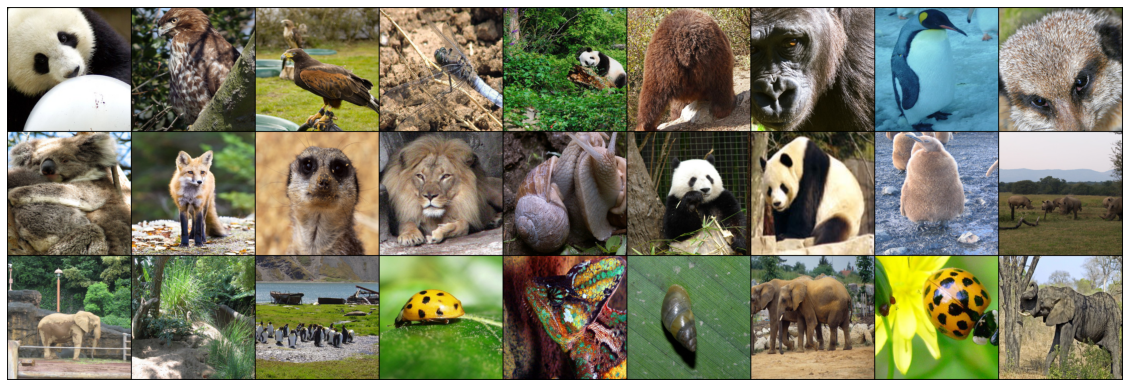

In [ ]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

# Training on ResNet30

Total number of parameters is: 21312324
Epoch: 0, Iteration 0, loss = 5.3379
Epoch: 0, Iteration 10, loss = 4.4023
Epoch: 0, Iteration 20, loss = 2.9011
Epoch: 0, Iteration 30, loss = 4.0230
Epoch: 0, Iteration 40, loss = 3.3987
Epoch: 0, Iteration 50, loss = 4.5950
Epoch: 0, Iteration 60, loss = 2.9690
Epoch: 0, Iteration 70, loss = 2.8299
Epoch: 0, Iteration 80, loss = 3.5898
Epoch: 0, Iteration 90, loss = 2.6060
Epoch: 0, Iteration 100, loss = 2.6728
Epoch: 0, Iteration 110, loss = 2.6631
Epoch: 0, Iteration 120, loss = 2.5446
Epoch: 0, Iteration 130, loss = 3.3205
Epoch: 0, Iteration 140, loss = 2.6290
Epoch: 0, Iteration 150, loss = 2.5069
Epoch: 0, Iteration 160, loss = 2.9936
Epoch: 0, Iteration 170, loss = 2.3959
Epoch: 0, Iteration 180, loss = 2.6378
Epoch: 0, Iteration 190, loss = 2.7005
Epoch: 0, Iteration 200, loss = 3.1821
Epoch: 0, Iteration 210, loss = 2.3939
Epoch: 0, Iteration 220, loss = 2.6881
Epoch: 0, Iteration 230, loss = 2.6996
Epoch: 0, Iteration 240, loss = 2.7

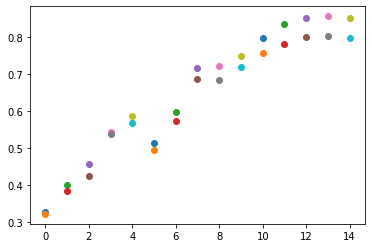

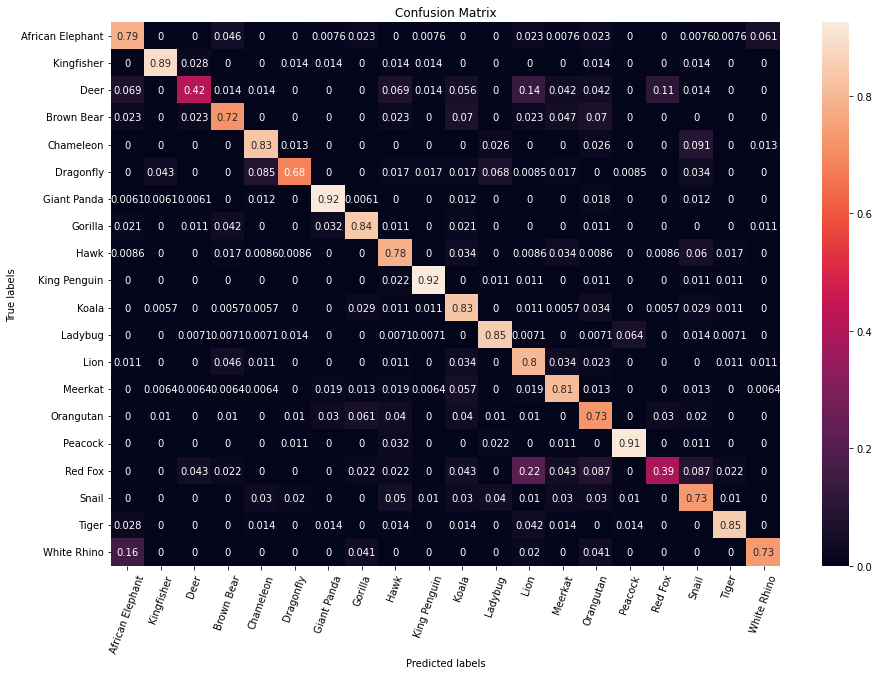

Predicted label ['Dragonfly' 'White Rhino']
True label ['Peacock' 'Lion']
Corresponding images are shown below


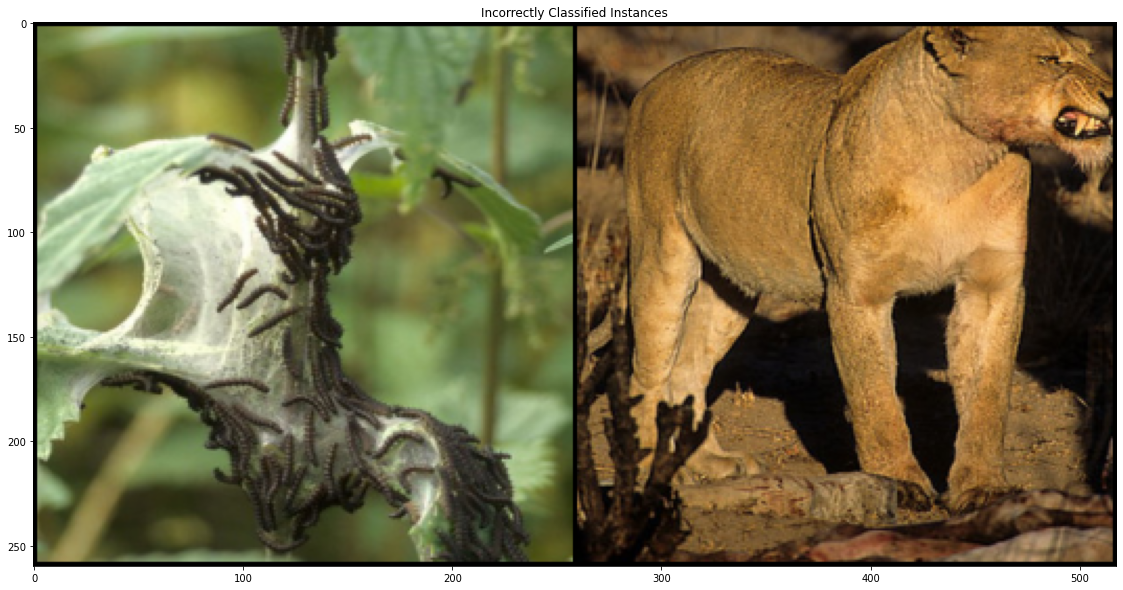

In [ ]:
model = ResNet30()

# Use large-ish learning rate of 0.001 to allow for larger updates to
# reduce overfitting (larger updates can get optimizer out of local minima).
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=0.0000001) 

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

# Train the model with 15 epochs
train_part(model, optimizer, epochs = 15)

# report test set accuracy
check_accuracy(loader_val, model, analysis=True)

# save the model
torch.save(model.state_dict(), 'model.pt')

---

# Performance evaluation


Got 1566 / 2000 correct (78.30)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


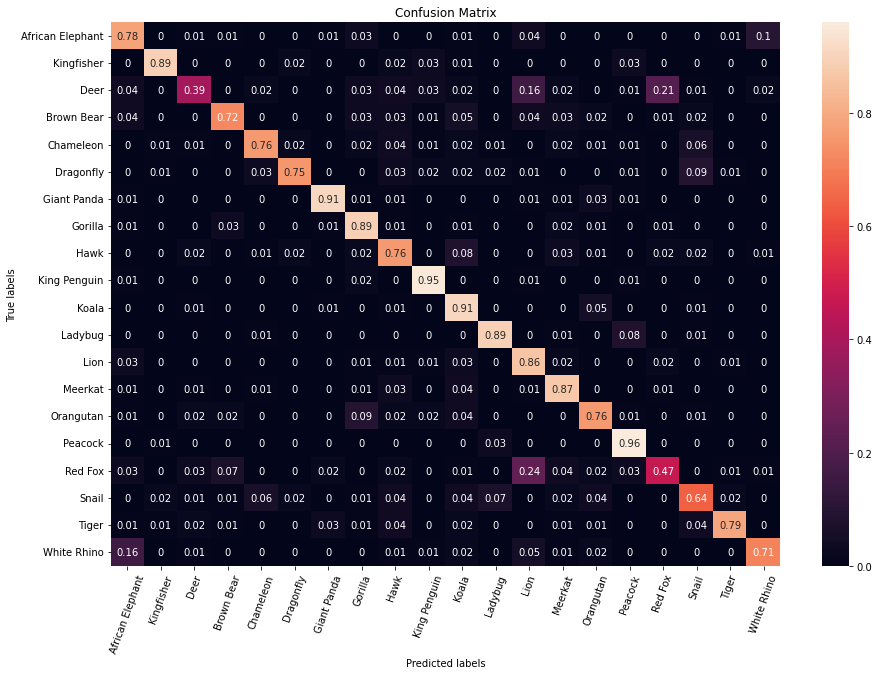

Predicted label ['Orangutan' 'Brown Bear' 'Brown Bear']
True label ['Red Fox' 'Red Fox' 'Gorilla']
Corresponding images are shown below


0.783

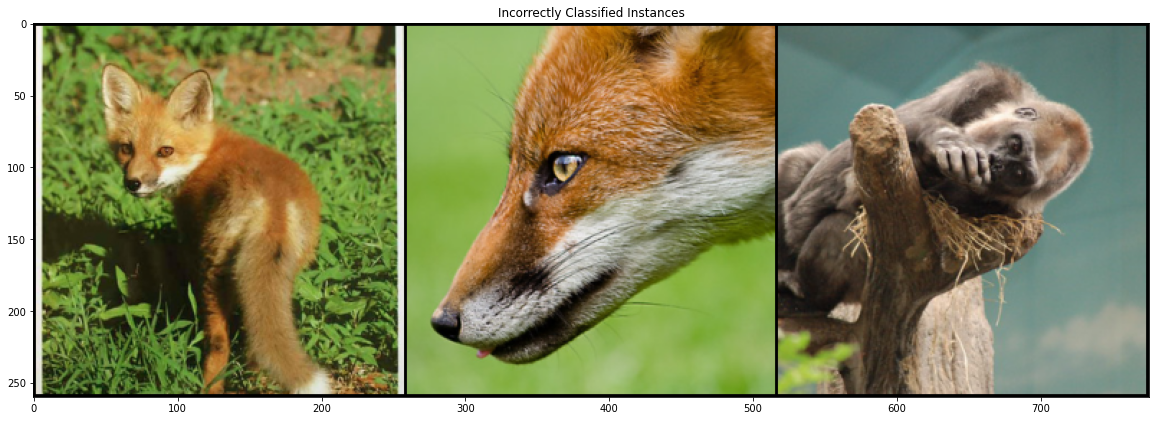

In [ ]:
# Compute accuracy on test set, show confusion matrix, and visualise some incorrectly 
# classified images
check_accuracy(loader_test, model, analysis=True)

## Analysis of performance

Hyperparameters were chosen by understanding the source of weak performance in the model by plotting the learning curves for the train and validation set, and determining whether the cause of weak performance was due to bias (low train accuracy vs best possible performance (e.g. human performance)), variance (large drop-off between train accuracy and validation accuracy), or both (large difference between train and test accuracy, at a low train accuracy level). For high bias/underfitting I increased model complexity (more depth /wider layers), reduced regularization terms, train longer; for high variance I augmented the training data, reduced model complexity, increased regularization, used early stopping, etc.. Then I re-evaluated whether bias or variance were present, and repeated the process.

Accuracy on the train set is 85.1%, on the validation set 79.9%, and 78.3% on the test set. Given computational resource limits, this performance is ok, however, could almost certainly still be improved on:

1) Training accuracy of 85.1% is likely still lower than best possible accuracy implied by Bayes error (in this instance, likely human level performance), indicating that some bias/underfitting may still be present. There are a number of things we could try: train for longer / more epochs (though the reported learning curves seem to be levelling off after 13-15 epochs); move to a more complex model (like Resnet-101); or dynamically reduce the learning rate parameter for later epochs to avoid the loss on the training set "bouncing up and down" (e.g. see log on epoch 14 where loss is quite unstable for consecutive iterations, rather than trending down). Increasing the batch_size for later epochs may also help in this regard, as on average there will be less variability in the data for larger batches.

2) In terms of variance/overfitting, there is still some present, with c. 5 percentage point differential between train and validation set accuracy. One improvement one could try here (particularly if we increase model complexity) is to increase the number of random augmentations to the data (including rotations, blurrring, slight color shifts, etc.), which should allow the model to generalize even better by "seeing" more varied examples for the same class (other standard procedures like increasing regularizaton could also be tried). 

3) One of the most interesting improvements, however, comes from looking at the confusion matrix (for the validation and test set). Here we see that some classes report much lower accuracy than the overall model accuracy, namely the 'Deer' (39% acc on test; appears to get confused most often with a 'Lion' and a 'Red Fox'), the 'Red Fox' (47% acc on test; gets confused most often with a 'Lion'), and potentially the 'Snail' (64% acc on test; some confusion with a 'Ladybug). One should try to obtain more images from the most affected classes (deer, red fox, lion, (snail)), to allow the model to generalise better for them rather than memorize. Including particularly difficult images (e.g. where the environment in which the animals are standing and the animals pose and camera angle are similar) should nudge the network to learn patterns specific to each animal class. More generally, one should evaluate how balanced the dataset is (e.g. count of examples per class), and then try to increase the number of examples in the least represented classes to make the dataset more balanced.